In [69]:
import mysql.connector
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
conn = mysql.connector.connect(host='localhost',database='my_db',user='my_db_user')

In [71]:
cur = conn.cursor()

In [72]:
payments_df = pd.read_excel("payments.xls")

In [73]:
APPLICATIONS_TABLE = 'applications'
CONTRACTS_TABLE = 'contracts'
PAYMENTS_TABLE = 'payments'
DEFAULTS_TABLE = 'defaults'

In [74]:
cur.execute("""
DROP TABLE IF EXISTS %s
""" % PAYMENTS_TABLE)

In [75]:
cur.execute("""
DROP TABLE IF EXISTS %s
""" % DEFAULTS_TABLE)

In [76]:
cur.execute("""
CREATE TABLE %s (
    id INT AUTO_INCREMENT,
    contract_number INT NOT NULL,
    date DATE,
    amnt_due FLOAT,
    amnt_paid FLOAT,
    FOREIGN KEY (contract_number) REFERENCES %s(contract_number) ON DELETE CASCADE,
    PRIMARY KEY (id)
)  ENGINE=INNODB;
""" % (PAYMENTS_TABLE, CONTRACTS_TABLE))

In [77]:
cur.execute("""
CREATE TABLE %s (
    id_number INT NOT NULL,
    default_date DATE,
    FOREIGN KEY (id_number) REFERENCES %s(id_number) ON DELETE CASCADE,
    PRIMARY KEY (id_number)
)  ENGINE=INNODB;
""" % (DEFAULTS_TABLE, APPLICATIONS_TABLE))

In [78]:
no_contracts = set()
for ind in payments_df.index:
    row = payments_df.loc[ind]
    cur.execute("SELECT 1=1 FROM %s WHERE contract_number=%d" % (CONTRACTS_TABLE, int(row['Contract Number'])))
    if cur.fetchone():
        cur.execute("INSERT INTO %s (contract_number, date, amnt_due, amnt_paid) VALUES (%d, '%s', %f, %f)" % (PAYMENTS_TABLE, 
                                                                                                         row['Contract Number'],
                                                                                                         row['Date'],
                                                                                                         row['Amount Due'],
                                                                                                         row['Amount Paid']))
    else:
        no_contracts.add(int(row['Contract Number']))
print("There are no contracts with numbers:", no_contracts)
conn.commit()

There are no contracts with numbers: {100875}


In [79]:
payments_df = pd.read_sql_query("SELECT * FROM %s" % PAYMENTS_TABLE, conn, index_col='id')

In [80]:
s_dates = payments_df.groupby(['contract_number'], as_index=False).agg({'date': 'min'})

In [81]:
s_dates['amnt_due'] = np.nan
s_dates['amnt_paid'] = np.nan

In [82]:
for ind in s_dates.index:
    row = s_dates.loc[ind]
    t_df = payments_df[(payments_df.contract_number == row.contract_number) & (payments_df.date == row.date)]
    s_dates.loc[ind, 'amnt_due'] = t_df.amnt_due.iloc[0]
    s_dates.loc[ind, 'amnt_paid'] = t_df.amnt_paid.iloc[0]

In [83]:
if np.any(s_dates.amnt_paid - s_dates.amnt_due < 0):
    mb_zero_default = s_dates[s_dates.amnt_paid - s_dates.amnt_due < 0].contract_number.unique()
    print("There may be overdues in the first period! Check contracts:", mb_zero_default)

In [84]:
# Заполняем количество дней просрочки

In [85]:
payments_df['overdue_days'] = -1  # Ставим -1, там, где не было просрочки, а 0 будем ставить там, где должен был быть платеж, но не произошёл

In [86]:
for contract in payments_df.contract_number.unique():
    temp_df = payments_df[payments_df.contract_number == contract].sort_values(['date'])
    # Получаем массив индексов, т.к. индексация в "частях" pandas.DataFrame остаётся как и в исходном
    index_arr = temp_df.index.tolist()
    for i in range(1, len(index_arr)):  # Берем индексы с 1, т.к. в 0 всегда просрочка 0 (первый платеж)
        prev_ind = index_arr[i - 1]
        ind = index_arr[i]
        if payments_df.loc[ind, 'amnt_paid'] < payments_df.loc[ind, 'amnt_due']:  # Платеж не поступил или был меньше
            if payments_df.loc[prev_ind, 'overdue_days'] == -1:  # Не было просрочки
                payments_df.loc[ind, 'overdue_days'] = 0  # С текущей даты пошла просрочка, но пока что 0
            else:
                # new_ov_days = (payments_df.loc[ind, 'date'] - payments_df.loc[prev_ind, 'date']).days  # Вычисляем кол-во дней просрочки
                # Для простоты будем просто добавлять 30, т.к. платежи ровно через 1 мес.
                new_ov_days = 30
                payments_df.loc[ind, 'overdue_days'] = payments_df.loc[prev_ind, 'overdue_days'] + new_ov_days  # Складываем прошлую просрочку с текущей
        elif payments_df.loc[ind, 'amnt_paid'] > payments_df.loc[ind, 'amnt_due']:
            months_covered = int(round(payments_df.loc[ind, 'amnt_paid'] / payments_df.loc[ind, 'amnt_due'], 0))  # Считаем, за сколько месяцев оплатил
            months_covered = months_covered - 1  # Вычитаем 1 месяц из погашения, т.к. мы не прибавили 30 дней за текущий месяц
            # Вычитаем из просрочки количество "погашенных" просроченных платежей
            # В случае более сложного начисления (с процентами, неравномерные платежи) надо использовать логику сложнее
            payments_df.loc[ind, 'overdue_days'] = payments_df.loc[prev_ind, 'overdue_days'] - months_covered * 30
            if payments_df.loc[ind, 'overdue_days'] < 0:
                payments_df.loc[ind, 'overdue_days'] = -1  # Если погасил весь долг - нет просрочки

In [87]:
# Берем макс. дату выхода в просрочку 90+, т.к. вдруг клиент гасил просрочку 90 и возрашался в 60
default_dates = payments_df[payments_df.overdue_days == 90].groupby(['contract_number'], as_index=False).agg({"date": "max"})

In [88]:
print(default_dates.rename({"contract_number": "Contract Number", "date": "Default Date"}, axis=1))

   Contract Number Default Date
0           100052   2017-12-30
1           100375   2017-01-02
2           100668   2018-06-29
3           100684   2017-12-14
4           100901   2016-11-03


### 3.b

In [89]:
contracts_df = pd.read_sql_query("SELECT * FROM %s" % CONTRACTS_TABLE, conn, index_col='contract_number')

In [90]:
# Определяем дату договора и заёмщика
payments_df['contract_date'] = np.nan
payments_df['id_number'] = 0
for ind in payments_df.index:
    row = payments_df.loc[ind]
    payments_df.loc[ind, 'contract_date'] = contracts_df.loc[row.contract_number].contract_date
    payments_df.loc[ind, 'id_number'] = contracts_df.loc[row.contract_number].id_number

In [91]:
# Определяем "возраст" договора в месяцах на каждую дату
payments_df['age'] = 0
for contract in payments_df.contract_number.unique():
    temp_df = payments_df[payments_df.contract_number == contract].sort_values(['date'])
    index_arr = temp_df.index.tolist()
    contract_date = temp_df.contract_date.iloc[0]  # Берем первую дату договора из таблицы, т.к. они все одинаковые
    for i in range(0, len(index_arr)):
        ind = index_arr[i]
        curr_date = payments_df.loc[ind, 'date']
        curr_age = (curr_date.year - contract_date.year) * 12 + (curr_date.month - contract_date.month)
        payments_df.loc[ind, 'age'] = curr_age
# Такой алгоритм вычисления возраста не подойдёт для данных, у которых частота чаще, чем 1 раз в месяц

In [132]:
period_months = int(input("Please enter risk horizon (in months): "))

Please enter risk horizon (in months): 24


In [133]:
out_df = payments_df[payments_df.age == period_months][['contract_number', 
                                                        'date', 
                                                        'contract_date', 
                                                        'id_number', 
                                                        'age']].reset_index(drop=True)  # Берем только нужные поля и "сбрасываем" индекс (начинаем с 0)

In [134]:
out_df['Default?'] = False

In [135]:
for contract in out_df.contract_number.unique():
    if contract in default_dates.contract_number.values:
        default_date = default_dates[default_dates.contract_number == contract].date.iloc[0]
        current_date = out_df.loc[out_df.contract_number == contract, "date"].iloc[0]
        if current_date >= default_date:
            out_df.loc[(out_df.contract_number == contract), "Default?"] = True

In [136]:
# print(out_df.sort_values(['id_number', 'contract_number']).reset_index(drop=True).rename({"contract_number": "Contract", 
#                                                                                     "date": "Date",
#                                                                                     "contract_date": "Contract Date",
#                                                                                     "id_number": "Person ID",
#                                                                                     "age": "Age (months)"}, axis=1)[['Person ID', 'Age (months)', 'Default?']])

## 3.c

In [137]:
print(out_df.groupby(['id_number']).agg({"age": "max", "Default?": "max"}).rename({"age": "Age (months)"}, axis=1))

           Age (months)  Default?
id_number                        
100003               24     False
100007               24     False
100009               24     False
100010               24     False
100011               24     False
100014               24     False
100017               24     False
100018               24     False
100023               24     False
100025               24     False
100035               24     False
100040               24     False
100044               24     False
100048               24     False
100055               24     False
100060               24     False
100062               24     False
100069               24     False
100070               24     False
100072               24     False
100073               24     False


## 3.d

In [98]:
# Определяем клиентов-дефолтников
contracts_filter = ', '.join(default_dates.contract_number.unique().astype(str))
default_data = pd.read_sql_query("""
SELECT
     id_number,
     contract_number
FROM
    %s
WHERE
    contract_number IN (%s)
""" % (CONTRACTS_TABLE, contracts_filter), conn)

In [99]:
default_data

,id_number,contract_number
0,100047,100052
1,100049,100375
2,100056,100668
3,100031,100684
4,100050,100901


In [100]:
default_data['default_date'] = default_data.contract_number.apply(lambda x: default_dates.set_index('contract_number').loc[x].date)

In [101]:
default_clients = set(default_data.id_number.values)

In [188]:
# Выбираем нужные данные о клиентах
applications_df = pd.read_sql_query("""
SELECT
    *
FROM
    %s
""" % APPLICATIONS_TABLE, conn, index_col='id_number')

In [189]:
# Убираем ненужные колонки
applications_df.drop(["name", "application_date", 'city'], axis=1, inplace=True)

In [190]:
# Убираем клиента, по которому мало данных

In [191]:
applications_df.drop([100076], inplace=True)

In [192]:
# Заполняем пустые поля
applications_df.fillna(0.0, inplace=True)

In [193]:
applications_df['default'] = 0

In [194]:
applications_df.loc[applications_df.index.isin(default_clients), "default"] = 1

In [195]:
applications_df['age'] = (datetime.date.today() - applications_df.birth_date).apply(lambda x: x.days // 365)

In [196]:
applications_df.drop(['birth_date'], axis=1, inplace=True)

In [197]:
applications_df.income = pd.qcut(applications_df.income, 5)

In [198]:
def get_age_of_car_category(age):
    if age == 0:
        return '0'
    elif age <= 3:
        return '<=3'
    else:
        return '>3'

In [199]:
applications_df.age_of_car = applications_df.age_of_car.apply(get_age_of_car_category)

In [200]:
applications_df.age = pd.qcut(applications_df.age, 5)

In [201]:
quantilized_columns = ['income', 'age', 'age_of_car']

In [202]:
categorucal_columns = ['gender', 
                       'employed_by',
                       'education',
                       'marital_status',
                       'position',
                       'income_type',
                       'housing',
                       'house_ownership',
                       'children',
                       'family',
                       ]

In [203]:
choices = dict(zip(range(len(categorucal_columns + quantilized_columns)), sorted(categorucal_columns + quantilized_columns)))

In [204]:
for i in choices.keys():
    print("%d: %s" % (i, choices[i]))

0: age
1: age_of_car
2: children
3: education
4: employed_by
5: family
6: gender
7: house_ownership
8: housing
9: income
10: income_type
11: marital_status
12: position


In [205]:
column_choice = choices.get(int(input("Please choose column (default=0): ")), 0)

Please choose column (default=0): 4


## 3.e

In [206]:
coded_columns = categorucal_columns.copy()

In [207]:
coded_columns.remove('gender')
coded_columns.remove('house_ownership')
coded_columns.remove('children')
coded_columns.remove('family')

In [208]:
reverse_dicts = dict()
for column_name in coded_columns:
    cur.execute("SELECT * FROM %s_dict" % (column_name))
    temp_dict = {i[0]: i[1] for i in cur.fetchall()}
    reverse_dicts[column_name] = temp_dict 

In [209]:
for column_name in coded_columns:
    applications_df[column_name] = applications_df[column_name + '_id'].apply(lambda x: reverse_dicts[column_name][x])
    applications_df.drop([column_name + '_id'], axis=1, inplace=True)

In [210]:
temp_df = applications_df[[column_choice, 'default']].copy()

In [211]:
temp_df['event'] = temp_df.default
temp_df['non_event'] = 1 - temp_df.default

In [212]:
df_gb = temp_df.groupby([column_choice]).agg({"default": "sum", 
                                         "event": lambda x: x.sum() / temp_df.event.sum(), 
                                         "non_event": lambda x: x.sum() / temp_df.non_event.sum()})

In [213]:
df_gb['woe'] = np.log(np.clip(df_gb.event / df_gb.non_event, 0.001, np.inf))

In [214]:
df_gb['IV'] = (df_gb.event - df_gb.non_event) * df_gb.woe

In [215]:
df_gb.index = df_gb.index.astype(str)

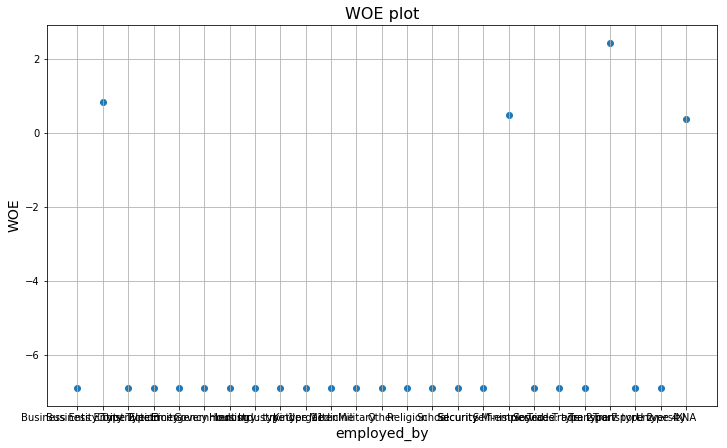

In [216]:
plt.figure(figsize=(12, 7));
plt.plot(list(range(df_gb.shape[0])), df_gb.woe, 'o-')
plt.grid()
plt.xticks(list(range(df_gb.shape[0])), df_gb.index)
plt.ylabel("WOE", fontsize=14)
plt.xlabel(column_choice, fontsize=14)
plt.title("WOE plot", fontsize=16)
plt.show()

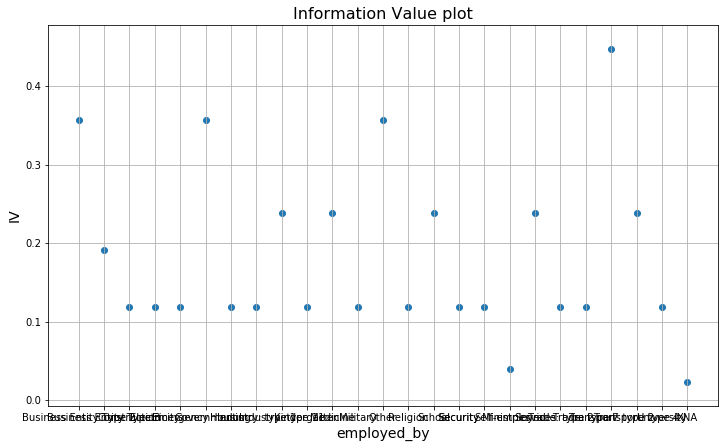

In [217]:
plt.figure(figsize=(12, 7));
plt.plot(list(range(df_gb.shape[0])), df_gb.IV, 'o-')
plt.grid()
plt.xticks(list(range(df_gb.shape[0])), df_gb.index)
plt.ylabel("IV", fontsize=14)
plt.xlabel(column_choice, fontsize=14)
plt.title("Information Value plot", fontsize=16)
plt.show()

In [181]:
df_gb.loc['SUM'] = df_gb.sum()

In [182]:
print(df_gb)

                               default  event  non_event       woe        IV
education                                                                   
Higher education                   1.0    0.2   0.293103 -0.382208  0.035585
Incomplete higher                  0.0    0.0   0.017241 -6.907755  0.119099
Secondary / secondary special      4.0    0.8   0.689655  0.148420  0.016377
SUM                                5.0    1.0   1.000000 -7.141544  0.171062


In [130]:
def_gb = default_data.groupby(['id_number'], as_index = False).agg({"default_date": "min"})

## 3.f

In [131]:
for id_number, default_date in def_gb.values:
    cur.execute("""
    INSERT INTO %s VALUES (%d, '%s')
    """ % (DEFAULTS_TABLE, id_number, default_date))
    
conn.commit()